In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt 
import os

In [2]:
conn = sqlite3.connect('../data/raw/td_V2.db')
git_commits = pd.read_sql_query("SELECT * FROM GIT_COMMITS",conn)
szz_fault_inducing_commits = pd.read_sql_query("SELECT * FROM SZZ_FAULT_INDUCING_COMMITS",conn)
refactoring_miner = pd.read_sql_query("SELECT * FROM REFACTORING_MINER",conn)
refactoring_miner = refactoring_miner[refactoring_miner["COMMIT_HASH"].isin(git_commits["COMMIT_HASH"])]

In [3]:
fault_commits = pd.read_csv("../data/processed/fault_commits.csv", encoding='utf8', engine='python')
refactor_commits = pd.read_csv("../data/processed/refactor_commits.csv", encoding='utf8', engine='python')

In [4]:
fault_commits = fault_commits[fault_commits["FAULT_INDUCING_COMMIT_HASH"].isin(szz_fault_inducing_commits["FAULT_INDUCING_COMMIT_HASH"])]

In [5]:
szz_fault_inducing_commits.head()

,PROJECT_ID,FAULT_FIXING_COMMIT_HASH,FAULT_INDUCING_COMMIT_HASH
0,org.apache:archiva,fa3688a693bc10bf53e72965027a82df0a8ad267,b7c003acb6b2c2a930443c511cb087d2776b4891
1,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,5f9755b5ae526a83ecdd219401c97498b223b776
2,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,9e37277c4a5d4c353f71ec5060951c554f20bab5
3,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,28898793f51c03b1259d3a1b1f1612f450cf634c
4,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,44dd185dade958e4c24014d84db71f870c714fcb


### Z-Test
We want to see if both populations are the same. Populations beeing commits with and without refactoring, looking into the number of faults in each group.

Null hypothesis: proportions are the same.

In [6]:
commit_refactor = len(refactoring_miner["COMMIT_HASH"].unique())
commit_no_refactor = sum(~pd.Series(git_commits["COMMIT_HASH"].unique()).isin(refactoring_miner["COMMIT_HASH"].unique()))

In [7]:
commit_refactor, commit_no_refactor

(7197, 146797)

In [8]:
fault_refactor = len(fault_commits["FAULT_INDUCING_COMMIT_HASH"].unique())
fault_no_refactor = sum(~pd.Series(szz_fault_inducing_commits["FAULT_INDUCING_COMMIT_HASH"].unique()).isin(fault_commits["FAULT_INDUCING_COMMIT_HASH"].unique()))

In [9]:
fault_refactor, fault_no_refactor

(1671, 15655)

In [10]:
p1 = fault_refactor/commit_refactor
print(round(p1, 2), '% of faults in refactor commits', sep = '')

0.23% of faults in refactor commits


In [11]:
p2 = fault_no_refactor/commit_no_refactor
print(round(p2, 2), '% of faults in non-refactor commits', sep = '')

0.11% of faults in non-refactor commits


In [12]:
p = (fault_refactor+fault_no_refactor)/(commit_refactor+commit_no_refactor)
print(round(p, 2), '% of faults in commits', sep = '')

0.11% of faults in commits


In [13]:
Z = (p1-p2)/np.sqrt(p*(1-p)*((1/commit_refactor)+(1/commit_no_refactor)))
print('Z-Test score: ', round(Z, 2), sep = '')

Z-Test score: 32.91


Z-zcore associated with 0.5% alpha level / 2 is 2.576.
Our Z-score is 32.91 > 2.576, so we can reject the null hypothesis and say that both populations are statistically different.

# Spearman correlation test

Through this test we will check the correlation between the number of refactorings in a project and a number of faults, and we will also see if it is significative.

In [14]:
# Build dataframe: for each project two columns: number of refactorings, number of faults
faults_project = []
for i in szz_fault_inducing_commits.PROJECT_ID.unique():
    #print('Project:', i)
    fault_refactor = len(fault_commits[fault_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique())
    fault_no_refactor = sum(~pd.Series(szz_fault_inducing_commits[szz_fault_inducing_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique()).isin(fault_commits[fault_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique()))
    commit_refactor = len(refactoring_miner[refactoring_miner.PROJECT_ID==i]["COMMIT_HASH"].unique())
    commit_no_refactor = sum(~pd.Series(git_commits[git_commits.PROJECT_ID==i]["COMMIT_HASH"].unique()).isin(refactoring_miner[refactoring_miner.PROJECT_ID==i]["COMMIT_HASH"].unique()))
    #print(round(fault_refactor/commit_refactor, 2), '% of faults in refactor commits', sep = '')
    #print(round(fault_no_refactor/commit_no_refactor, 2), '% of faults in non-refactor commits\n', sep = '')
    faults_project.append([i, commit_refactor ,fault_no_refactor + fault_refactor])
    
faults_project = pd.DataFrame(faults_project).rename(columns={0:'project_id',1:'n_refactorings',2:'n_faults'})
faults_project.head()

,project_id,n_refactorings,n_faults
0,org.apache:archiva,329,1297
1,org.apache:batik,389,492
2,org.apache:bcel,85,95
3,org.apache:beanutils,75,202
4,org.apache:cayenne,118,1423


In [15]:
import scipy.stats
scipy.stats.spearmanr(a = np.array(faults_project['n_refactorings']), b = np.array(faults_project['n_faults']))

SpearmanrResult(correlation=0.5987958401751505, pvalue=0.0007613225733627337)

The number of faults in a project and its number of refactorings has been found to have a correlation of 0.6 and a very small p-value, which indicates that indeed there is a positive correlation between these two attributes. This is another proof that as we have more refactorings we have more faults

### Plots of % and counts

In [16]:
szz_fault_inducing_commits.head()

,PROJECT_ID,FAULT_FIXING_COMMIT_HASH,FAULT_INDUCING_COMMIT_HASH
0,org.apache:archiva,fa3688a693bc10bf53e72965027a82df0a8ad267,b7c003acb6b2c2a930443c511cb087d2776b4891
1,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,5f9755b5ae526a83ecdd219401c97498b223b776
2,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,9e37277c4a5d4c353f71ec5060951c554f20bab5
3,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,28898793f51c03b1259d3a1b1f1612f450cf634c
4,org.apache:archiva,d4c85abfac8d0920549f20735caf0e4028149c5c,44dd185dade958e4c24014d84db71f870c714fcb


In [17]:
# study of the percentage of faults caused by refactor and non-refactor commits by project
faults_project = []
for i in szz_fault_inducing_commits.PROJECT_ID.unique():
    #print('Project:', i)
    fault_refactor = len(fault_commits[fault_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique())
    fault_no_refactor = sum(~pd.Series(szz_fault_inducing_commits[szz_fault_inducing_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique()).isin(fault_commits[fault_commits.PROJECT_ID==i]["FAULT_INDUCING_COMMIT_HASH"].unique()))
    commit_refactor = len(refactoring_miner[refactoring_miner.PROJECT_ID==i]["COMMIT_HASH"].unique())
    commit_no_refactor = sum(~pd.Series(git_commits[git_commits.PROJECT_ID==i]["COMMIT_HASH"].unique()).isin(refactoring_miner[refactoring_miner.PROJECT_ID==i]["COMMIT_HASH"].unique()))
    #print(round(fault_refactor/commit_refactor, 2), '% of faults in refactor commits', sep = '')
    #print(round(fault_no_refactor/commit_no_refactor, 2), '% of faults in non-refactor commits\n', sep = '')
    faults_project.append([i,fault_refactor/commit_refactor,fault_no_refactor/commit_no_refactor])

In [18]:
faults_project = pd.DataFrame(faults_project).rename(columns={0:'project_id',1:'faults_refactor',2:'faults_non_refactor'})
faults_project.head()

,project_id,faults_refactor,faults_non_refactor
0,org.apache:archiva,0.489362,0.135788
1,org.apache:batik,0.000000,0.074253
2,org.apache:bcel,0.176471,0.047962
3,org.apache:beanutils,0.360000,0.131579
4,org.apache:cayenne,0.432203,0.207407


In [19]:
faults_project.sort_values('faults_refactor', ascending=False).set_index('project_id')

,faults_refactor,faults_non_refactor
project_id,,
org.apache:zookeeper,0.785942,0.418457
org.apache:thrift,0.666667,0.391496
org.apache:httpclient,0.558499,0.236870
org.apache:jxpath,0.500000,0.087850
org.apache:archiva,0.489362,0.135788
org.apache:commons-jexl,0.488889,0.143675
org.apache:dbutils,0.482759,0.040789
org.apache:commons-io,0.457143,0.164811
org.apache:dbcp,0.450292,0.143854


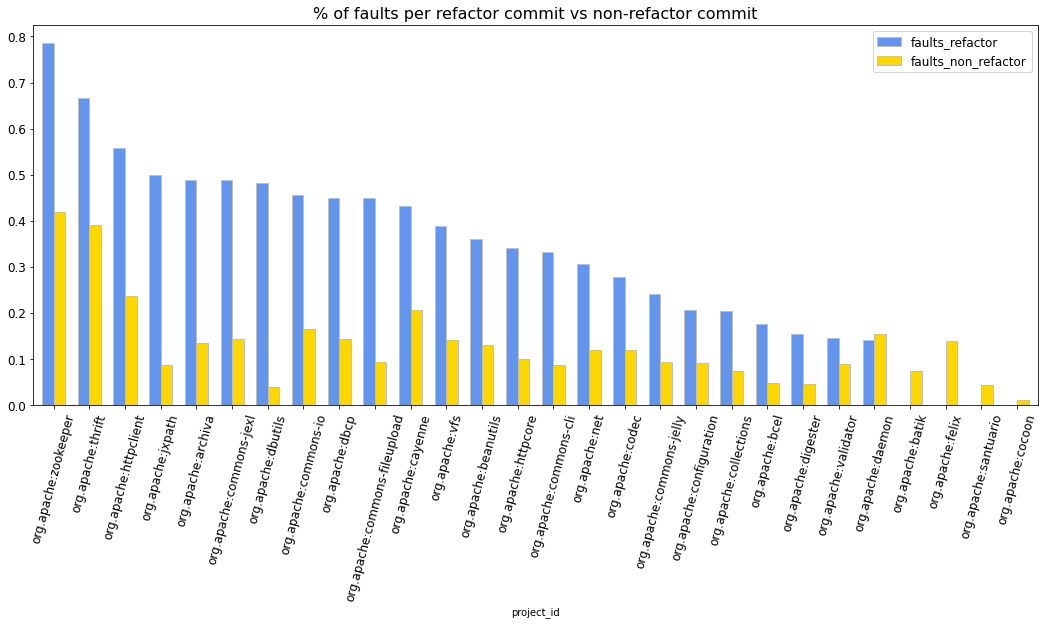

In [20]:
faults_project.sort_values('faults_refactor', ascending=False).set_index('project_id').plot(kind='bar', figsize=(18,7), rot=75, width=0.65, fontsize=12, \
                                            color=('cornflowerblue','gold'),edgecolor = 'silver')
plt.title('% of faults per refactor commit vs non-refactor commit', fontsize=16)
plt.legend(fontsize=12)

In [21]:
refactoring_miner.head()

,PROJECT_ID,COMMIT_HASH,REFACTORING_TYPE,REFACTORING_DETAIL
0,org.apache:batik,adbabd6f8adad3f9df936a5d61bc2984006d0666,Move Class,Move Class\torg.apache.batik.util.XMLConstants...
1,org.apache:batik,23df647cf944b6c33ab23f0433305c153e247839,Move Class,Move Class\torg.w3c.dom.events.CustomEvent mov...
2,org.apache:batik,23df647cf944b6c33ab23f0433305c153e247839,Move Class,Move Class\torg.w3c.dom.events.KeyboardEvent m...
3,org.apache:batik,23df647cf944b6c33ab23f0433305c153e247839,Move Class,Move Class\torg.w3c.dom.events.MutationNameEve...
4,org.apache:batik,23df647cf944b6c33ab23f0433305c153e247839,Move Class,Move Class\torg.w3c.dom.events.TextEvent moved...


In [22]:
# study of the faults caused by refactors by type of refactor
faults_refactor_type = []
faults_refactor_type_count = []

refactoring_miner.REFACTORING_TYPE.value_counts()
for i in refactoring_miner.REFACTORING_TYPE.unique():
    #print('Refactoring type:', i)
    fault_refactor = len(fault_commits[fault_commits.REFACTORING_TYPE==i]["FAULT_INDUCING_COMMIT_HASH"].unique())
    commit_refactor = len(refactoring_miner[refactoring_miner.REFACTORING_TYPE==i]["COMMIT_HASH"].unique())
    #print(round(fault_refactor/commit_refactor, 2), '% of faults in refactor commits\n', sep = '')
    faults_refactor_type.append([i, fault_refactor/commit_refactor])
    faults_refactor_type_count.append([i, fault_refactor])

In [23]:
faults_refactor_type = pd.DataFrame(faults_refactor_type).rename(columns={0:'refactor_type',1:'percent_faults'})
faults_refactor_type.head()

,refactor_type,percent_faults
0,Move Class,0.201835
1,Move Source Folder,0.068584
2,Rename Method,0.249867
3,Rename Package,0.189189
4,Extract Method,0.256757


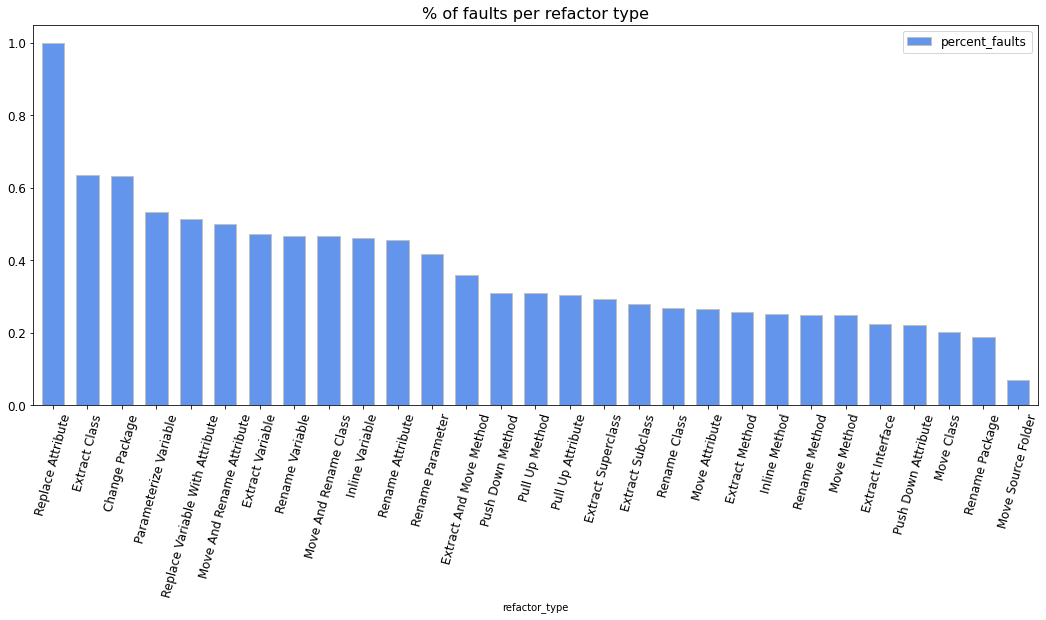

In [24]:
faults_refactor_type.sort_values('percent_faults', ascending=False).set_index('refactor_type').plot(kind='bar', figsize=(18,7), rot=75, width=0.65, fontsize=12, \
                                            color=('cornflowerblue'),edgecolor = 'silver')
plt.title('% of faults per refactor type', fontsize=16)
plt.legend(fontsize=12)

In [25]:
faults_refactor_type_count = pd.DataFrame(faults_refactor_type_count).rename(columns={0:'refactor_type',1:'faults'})
faults_refactor_type_count.head()

,refactor_type,faults
0,Move Class,154
1,Move Source Folder,31
2,Rename Method,471
3,Rename Package,14
4,Extract Method,532


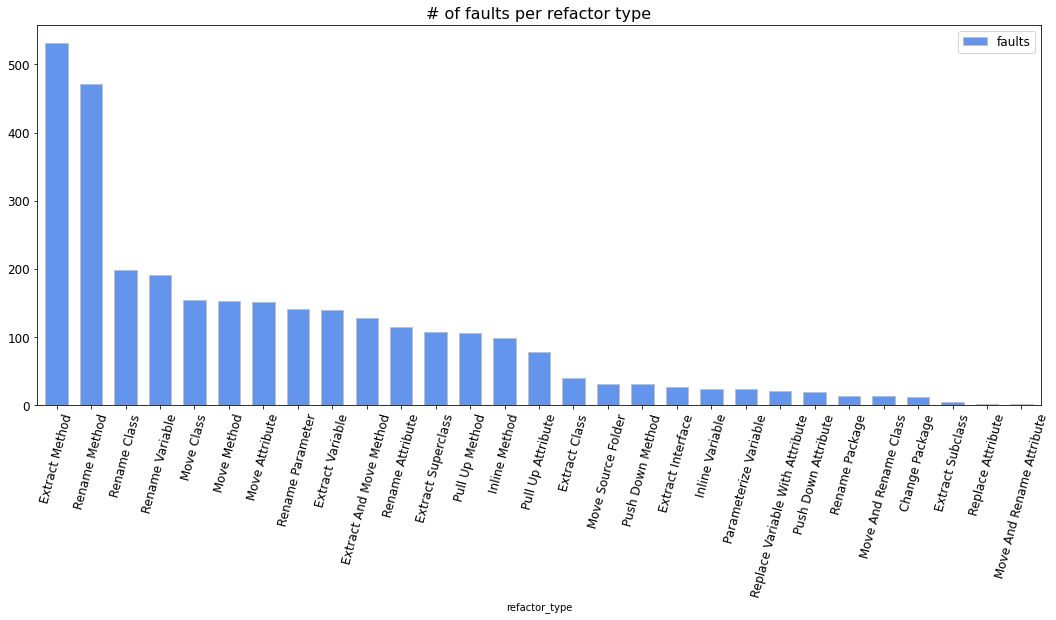

In [26]:
faults_refactor_type_count.sort_values('faults', ascending=False).set_index('refactor_type').plot(kind='bar', figsize=(18,7), rot=75, width=0.65, fontsize=12, \
                                            color=('cornflowerblue'),edgecolor = 'silver')
plt.title('# of faults per refactor type', fontsize=16)
plt.legend(fontsize=12)

In [27]:
projects_faults = {}

for i in szz_fault_inducing_commits.PROJECT_ID.unique():
    aux = {}
    for j in refactoring_miner.REFACTORING_TYPE.unique():
        faults = len(fault_commits[(fault_commits.PROJECT_ID==i) & (fault_commits.REFACTORING_TYPE==j)]["FAULT_INDUCING_COMMIT_HASH"].unique())
        aux[j] = faults
    projects_faults[i] = aux
    
pd.DataFrame(projects_faults).head()

,org.apache:archiva,org.apache:batik,org.apache:bcel,org.apache:beanutils,org.apache:cayenne,org.apache:cocoon,org.apache:codec,org.apache:collections,org.apache:commons-cli,org.apache:commons-fileupload,...,org.apache:felix,org.apache:jxpath,org.apache:net,org.apache:santuario,org.apache:thrift,org.apache:validator,org.apache:vfs,org.apache:zookeeper,org.apache:httpclient,org.apache:httpcore
Move Class,25,0,1,0,2,0,0,11,0,1,...,0,5,1,0,6,1,4,20,30,25
Move Source Folder,2,0,0,2,1,0,1,0,0,0,...,0,0,0,0,2,0,1,2,5,1
Rename Method,61,0,1,6,22,0,12,23,3,1,...,0,16,9,0,4,3,27,36,91,64
Rename Package,5,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,5,2
Extract Method,55,0,0,7,13,0,11,19,4,4,...,0,15,16,0,9,3,41,103,64,42


In [28]:
projects_refactor = {}

for i in refactoring_miner.PROJECT_ID.unique():
    aux = {}
    for j in refactoring_miner.REFACTORING_TYPE.unique():
        faults = len(refactoring_miner[(refactoring_miner.PROJECT_ID==i) & (refactoring_miner.REFACTORING_TYPE==j)]["COMMIT_HASH"].unique())
        aux[j] = faults
    projects_refactor[i] = aux
    
pd.DataFrame(projects_refactor).head()

,org.apache:batik,org.apache:cocoon,org.apache:bcel,org.apache:beanutils,org.apache:commons-cli,org.apache:codec,org.apache:collections,org.apache:configuration,org.apache:daemon,org.apache:dbcp,...,org.apache:vfs,org.apache:felix,org.apache:httpclient,org.apache:httpcore,org.apache:santuario,org.apache:zookeeper,org.apache:archiva,org.apache:hive,org.apache:cayenne,org.apache:thrift
Move Class,44,136,4,1,1,1,29,21,0,4,...,10,176,50,87,14,26,58,8,5,8
Move Source Folder,32,154,3,5,2,3,4,2,1,1,...,14,78,20,16,3,16,14,4,2,3
Rename Method,96,258,10,12,10,47,111,101,1,20,...,55,333,148,162,70,42,99,37,46,7
Rename Package,2,13,0,0,0,0,0,0,0,0,...,0,22,11,15,1,0,6,2,0,0
Extract Method,153,211,16,25,14,34,58,170,1,25,...,81,407,105,106,92,119,106,35,24,11


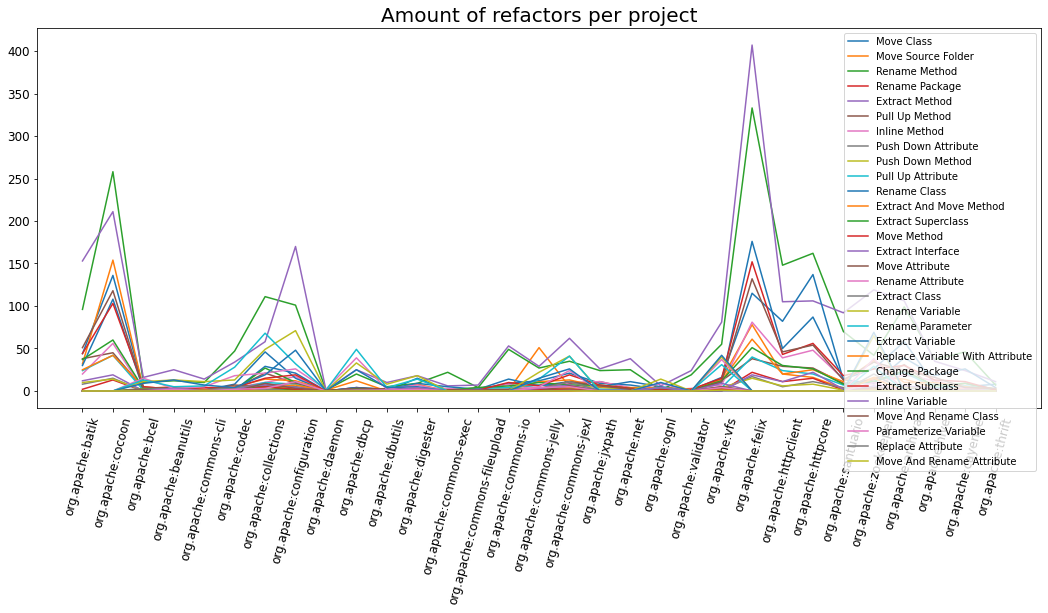

In [29]:
# to check the correlation between the kind of refactor and the project -> absolute number of refactors
(pd.DataFrame(projects_refactor).transpose()).plot(kind='line', figsize=(18,7), rot=75, fontsize=12)
plt.title('Amount of refactors per project', fontsize=20)
plt.xticks(np.arange(len(pd.DataFrame(projects_refactor).columns.to_list())), pd.DataFrame(projects_refactor).columns.to_list())
plt.show()

In [30]:
# relative number of refactors (% of each project)
amt_projects_refactor = pd.DataFrame(projects_refactor).transpose()
amt_projects_refactor['Total_amt'] = amt_projects_refactor.sum(axis=1)
amt_projects_refactor = amt_projects_refactor.div(amt_projects_refactor['Total_amt'], axis=0).drop(columns='Total_amt')

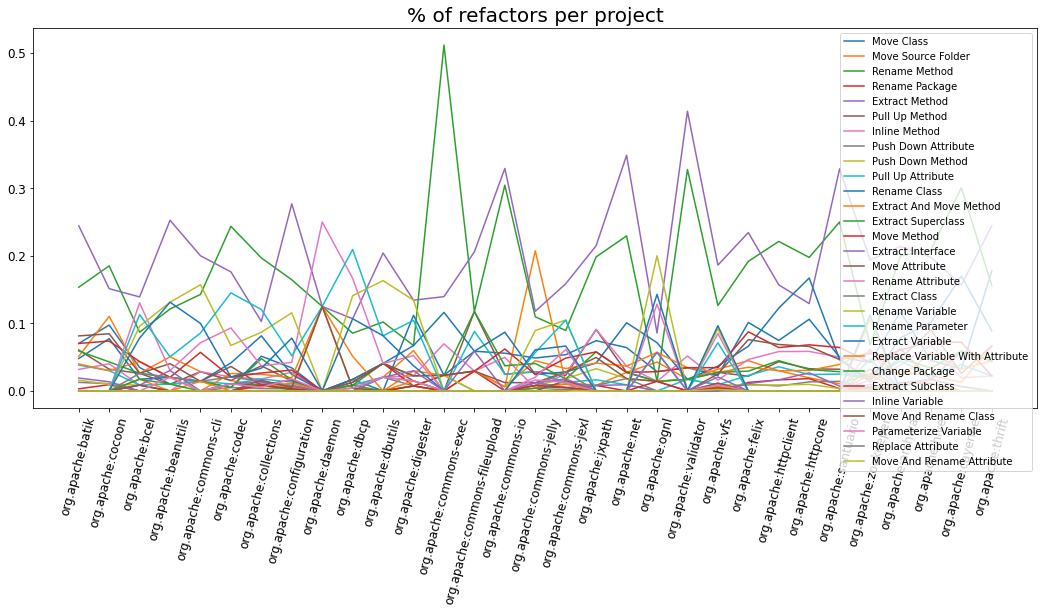

In [31]:
amt_projects_refactor.plot(kind='line', figsize=(18,7), rot=75, fontsize=12)
plt.title('% of refactors per project', fontsize=20)
plt.xticks(np.arange(len(amt_projects_refactor.index.to_list())), amt_projects_refactor.index.to_list())
plt.show()

/home/lena/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


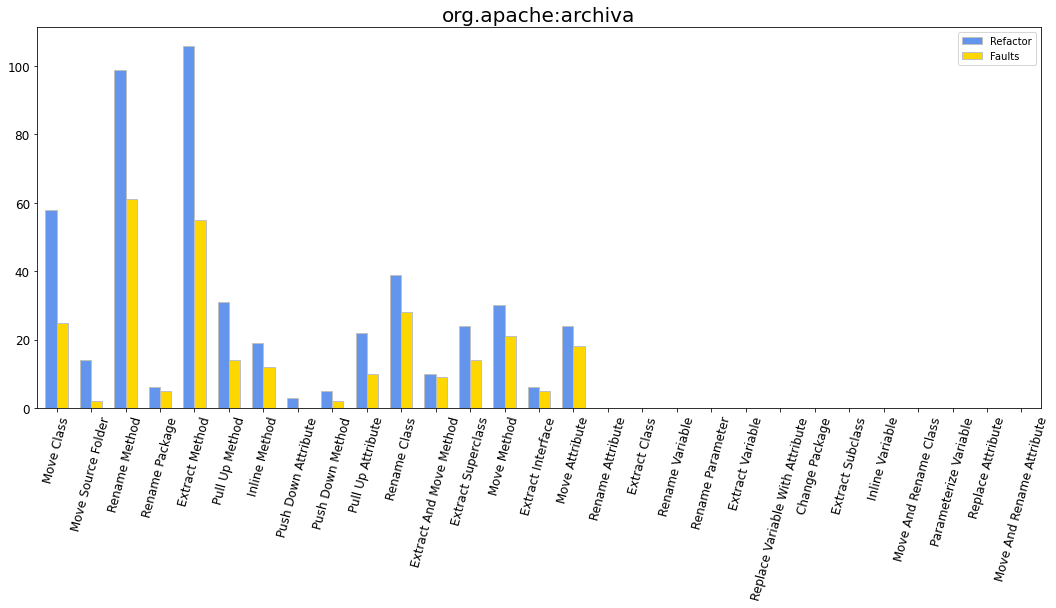

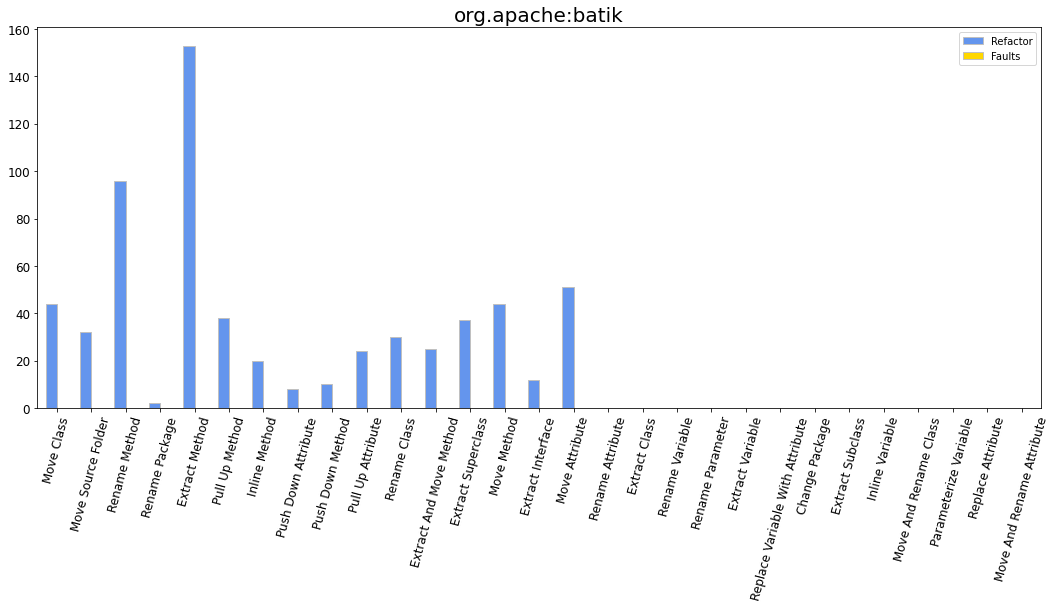

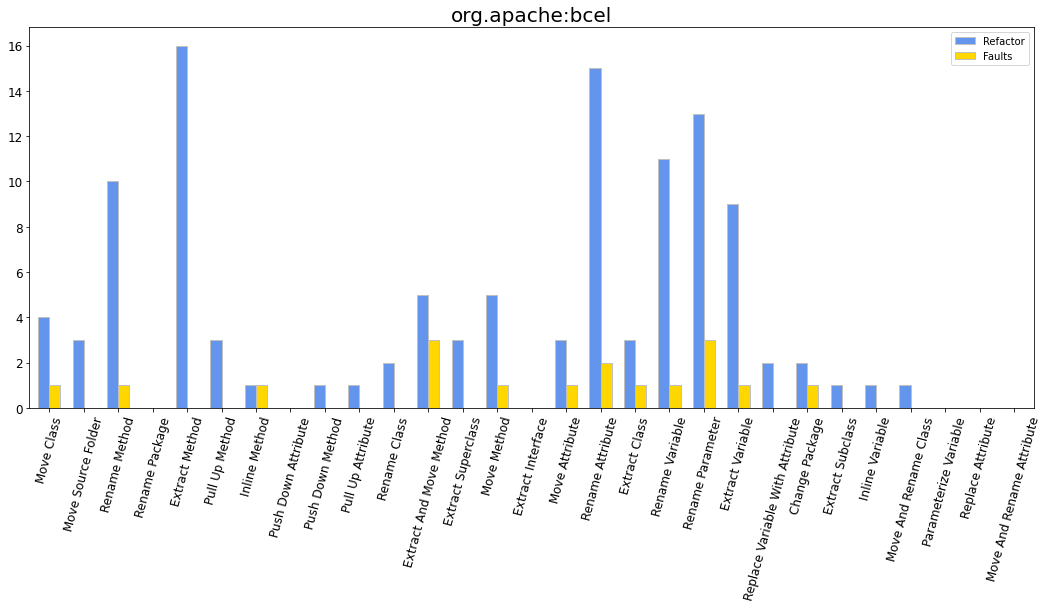

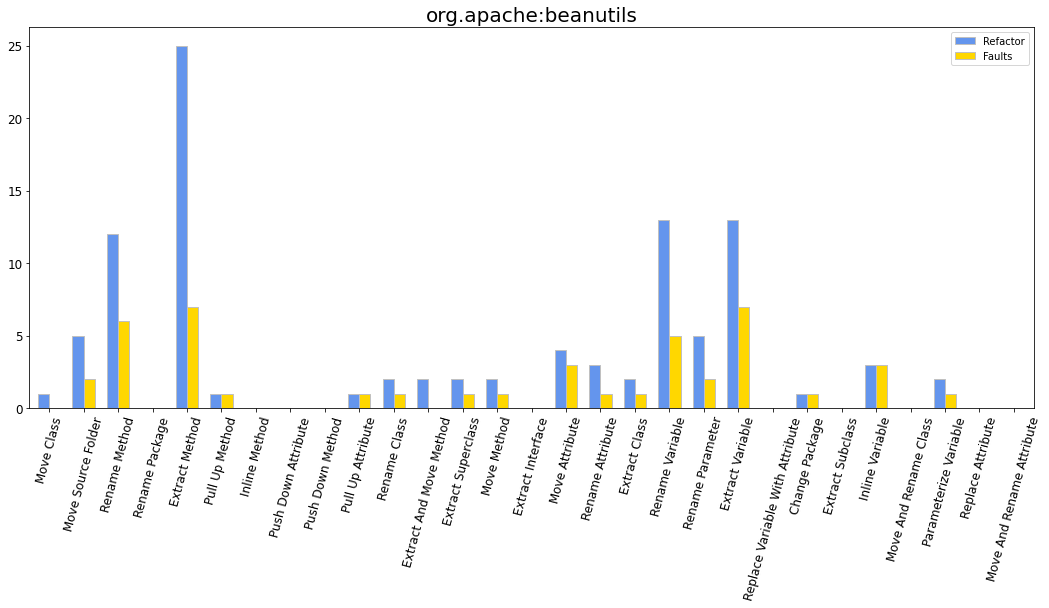

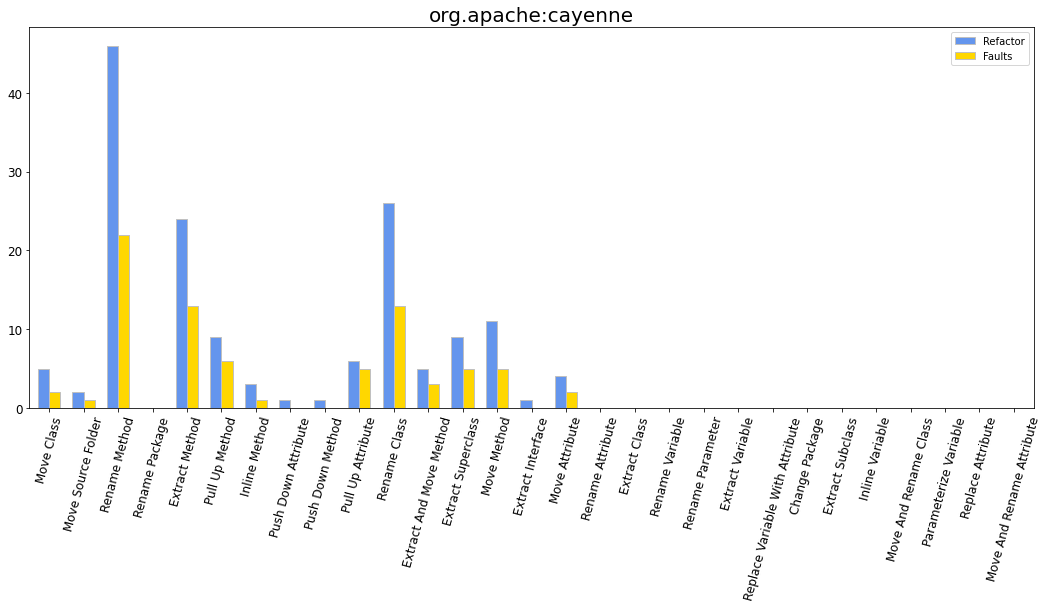

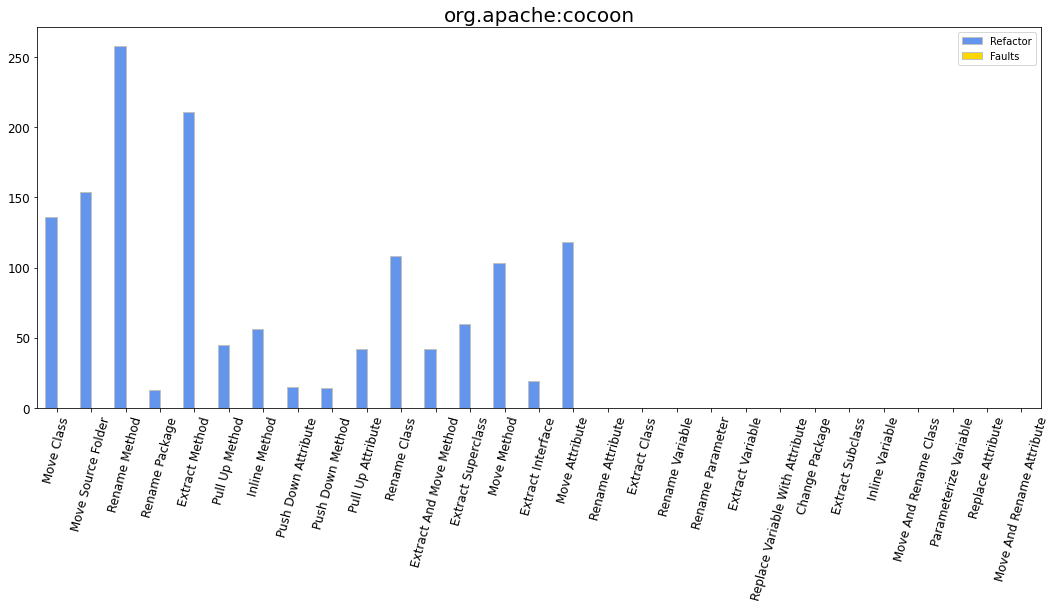

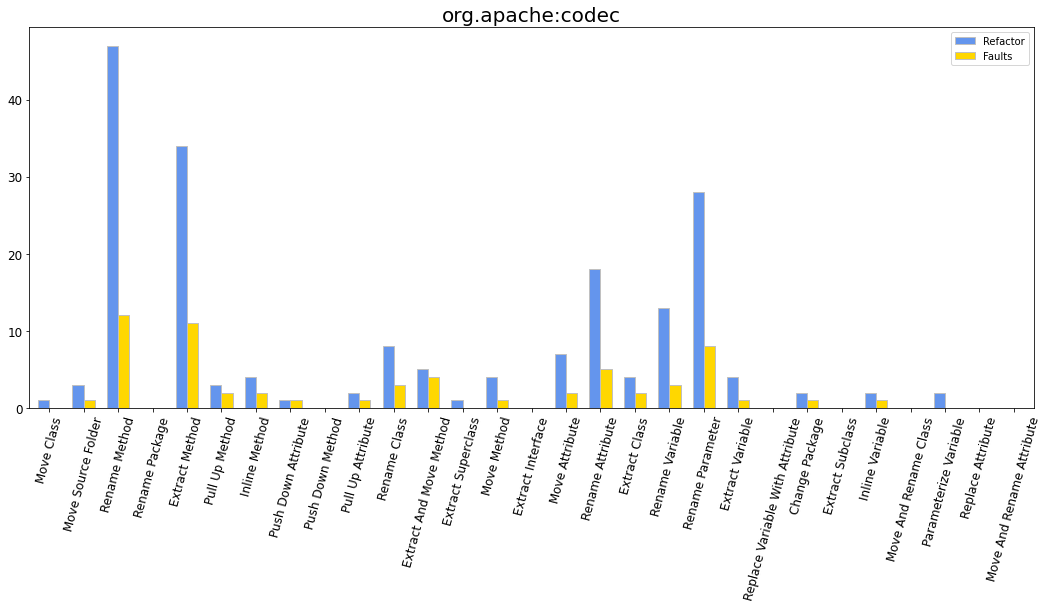

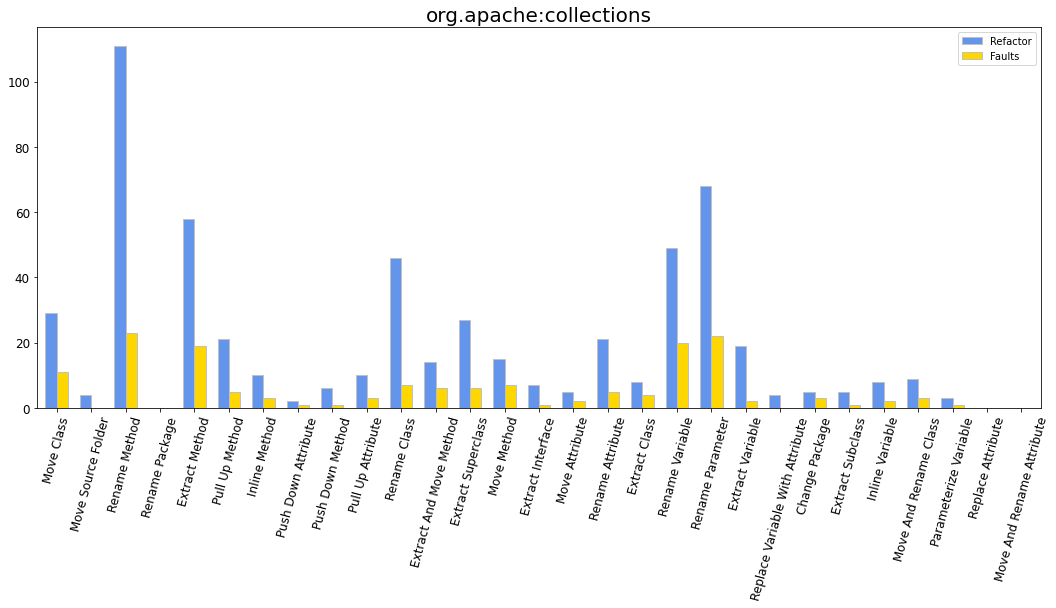

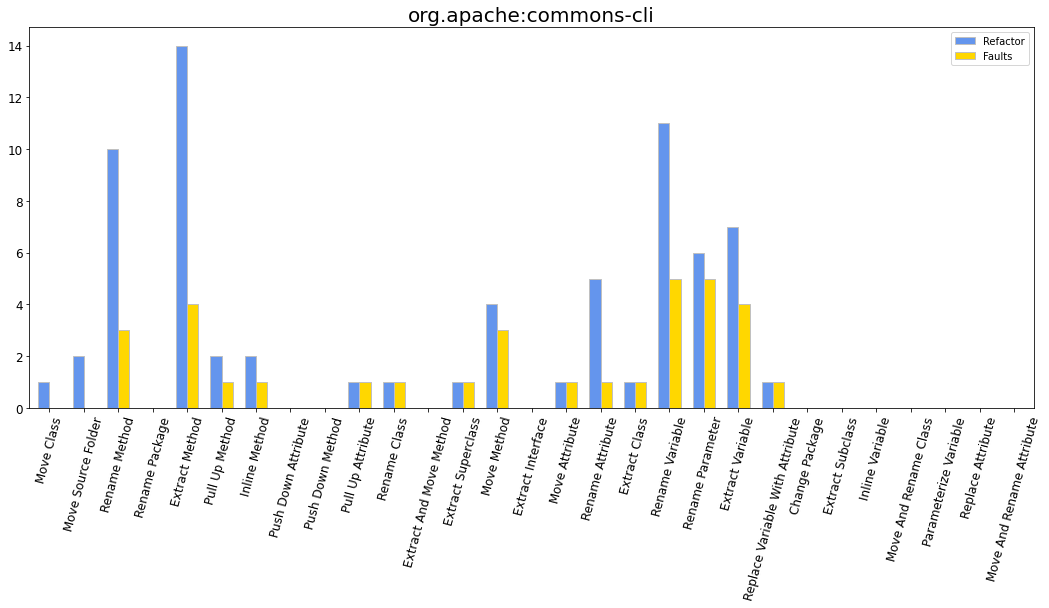

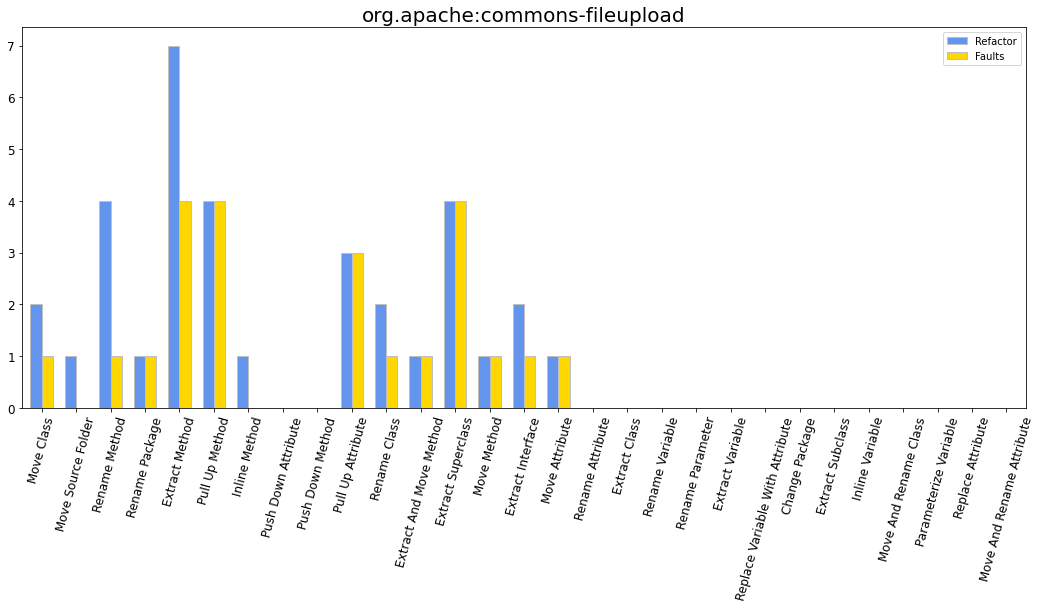

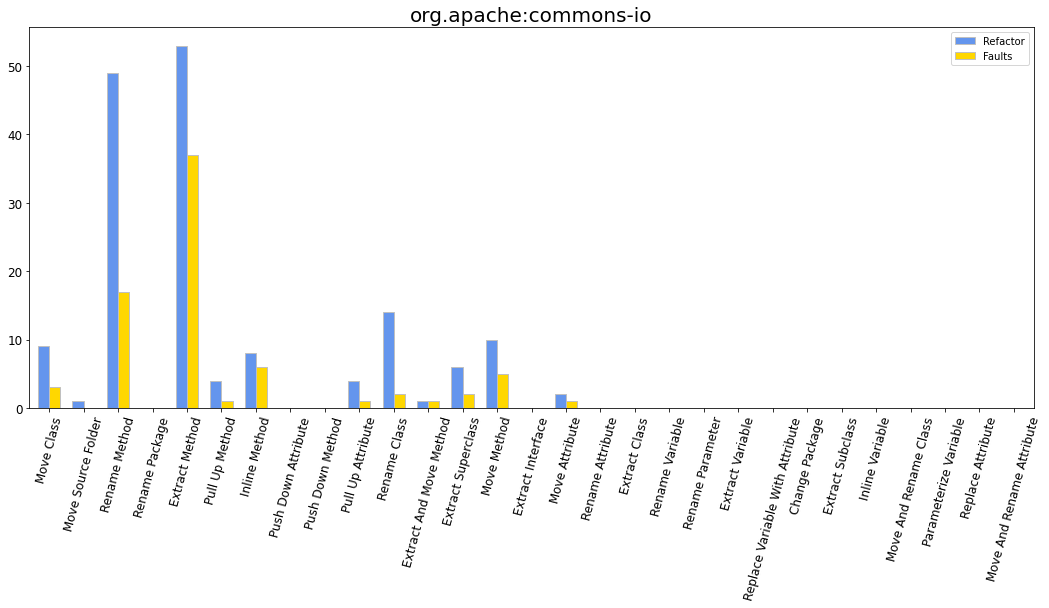

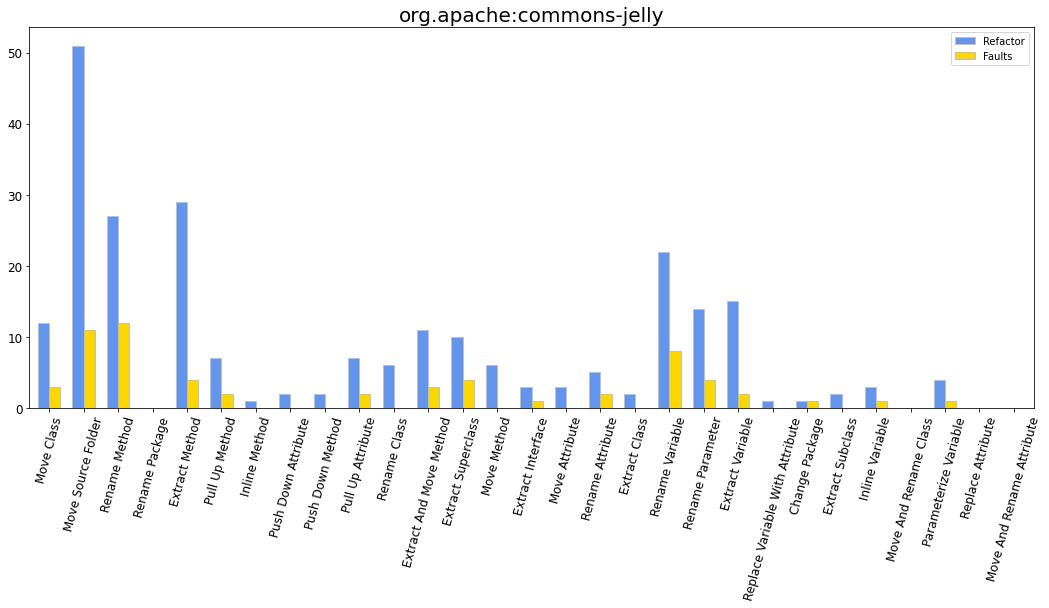

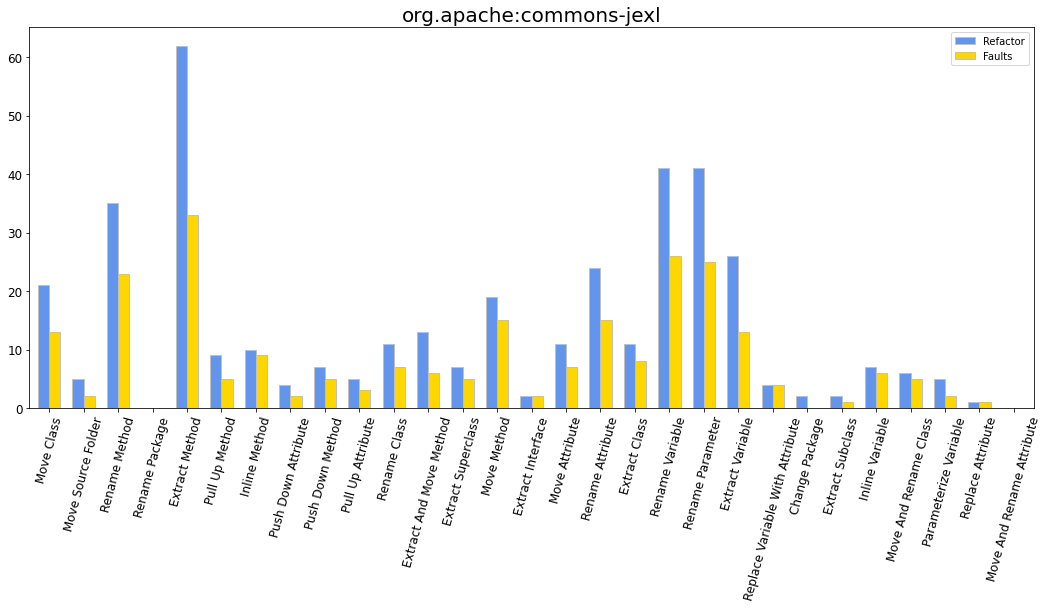

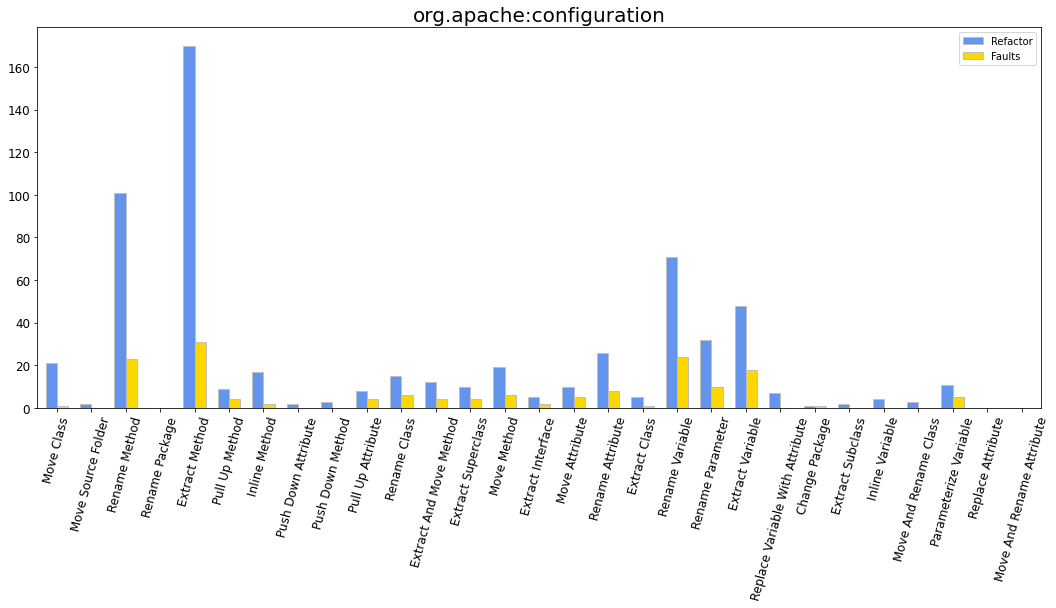

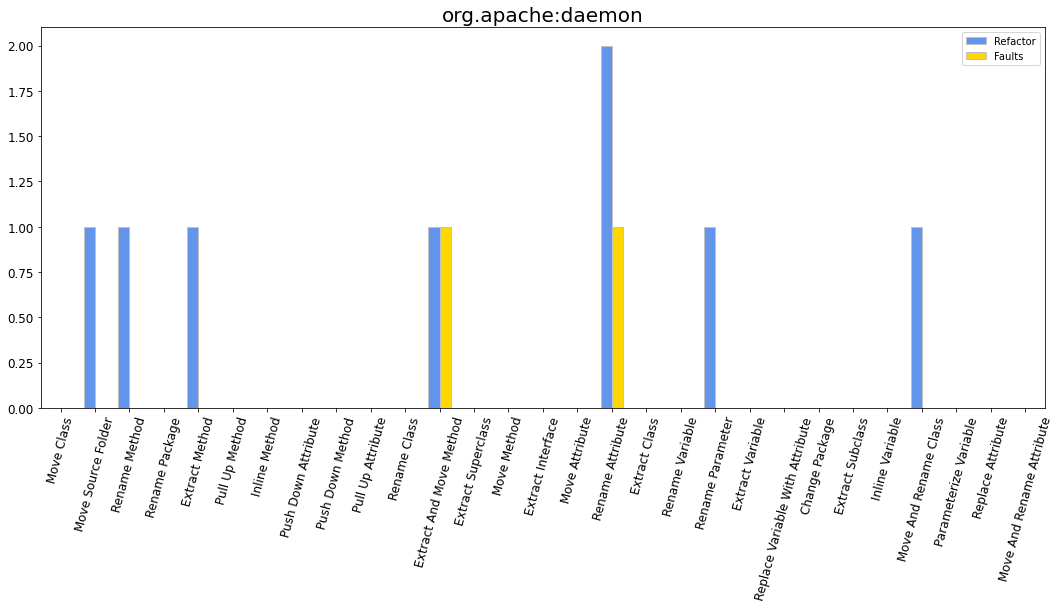

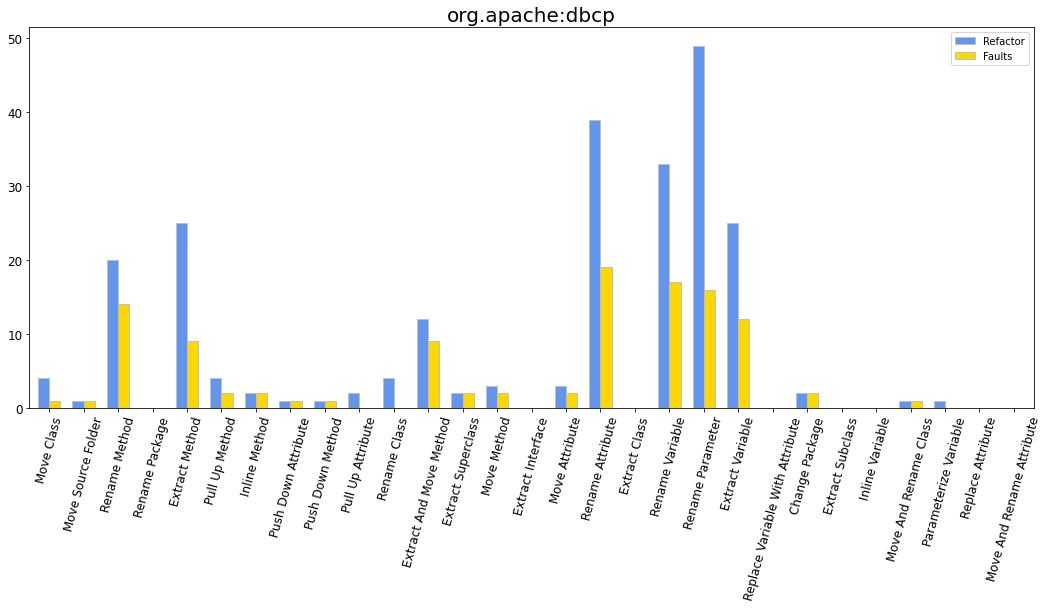

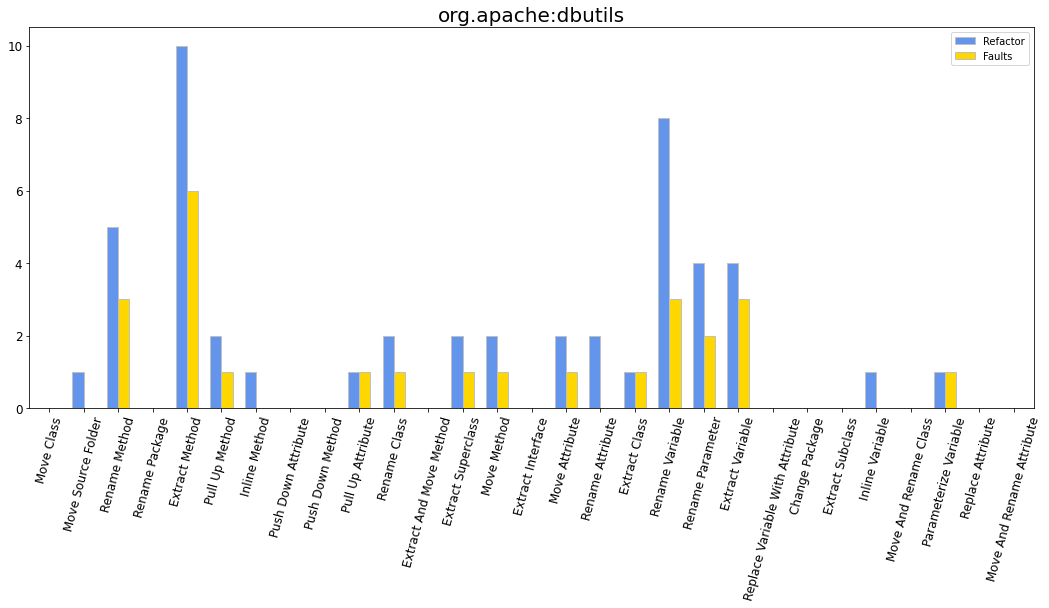

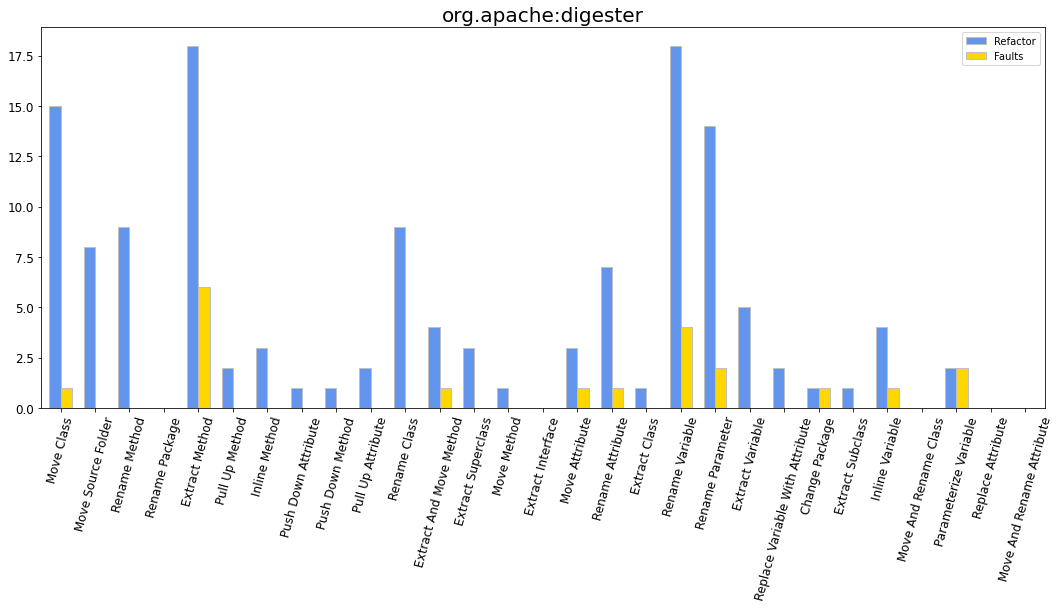

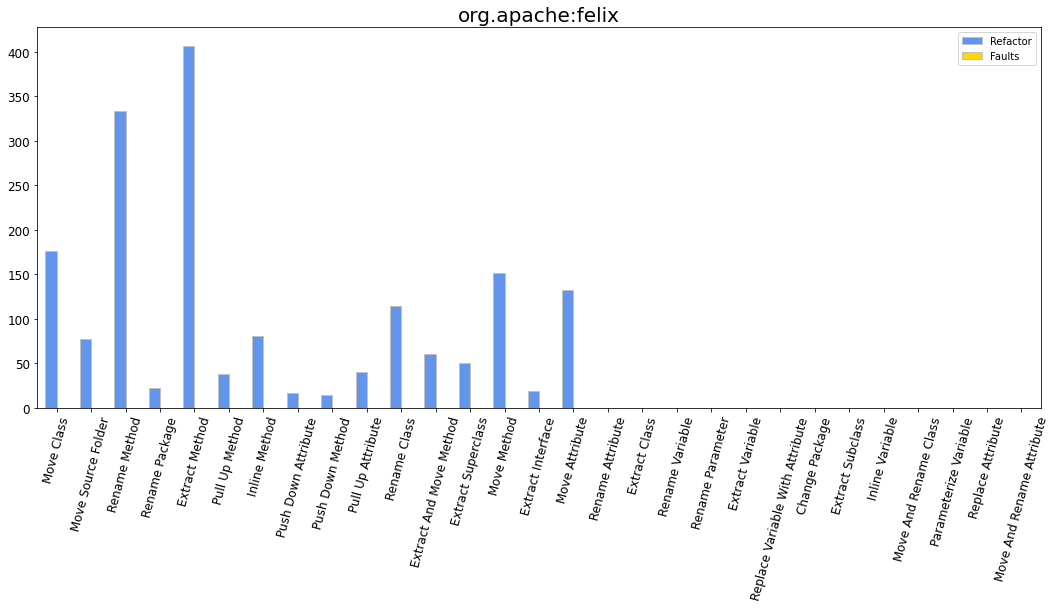

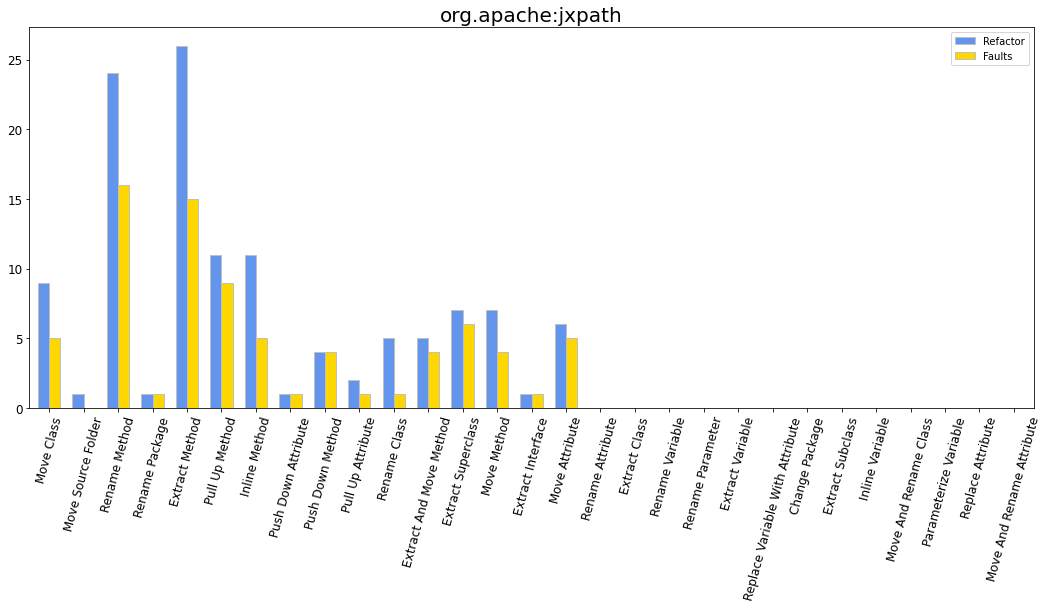

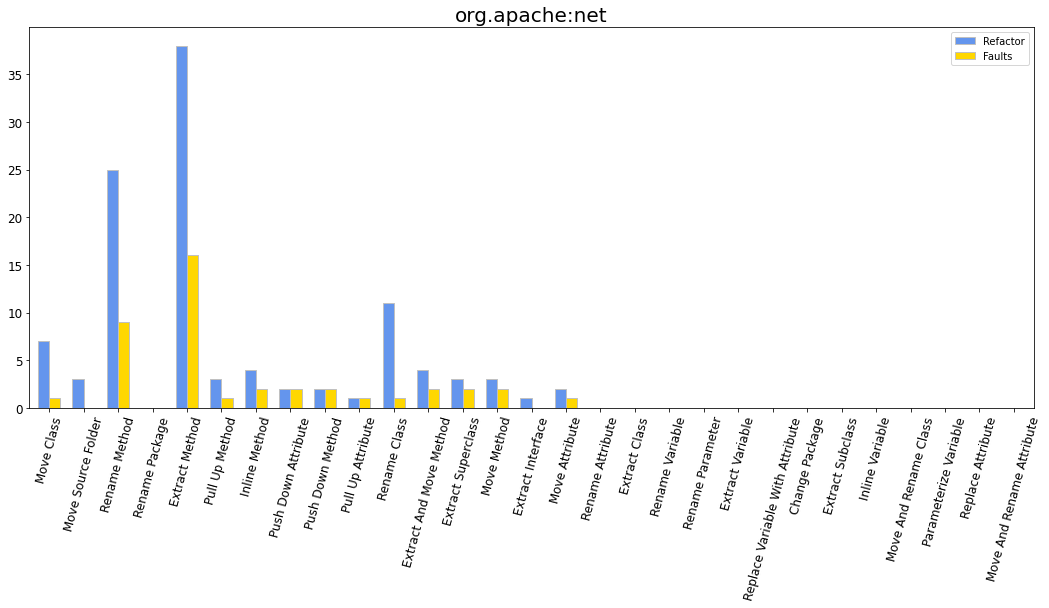

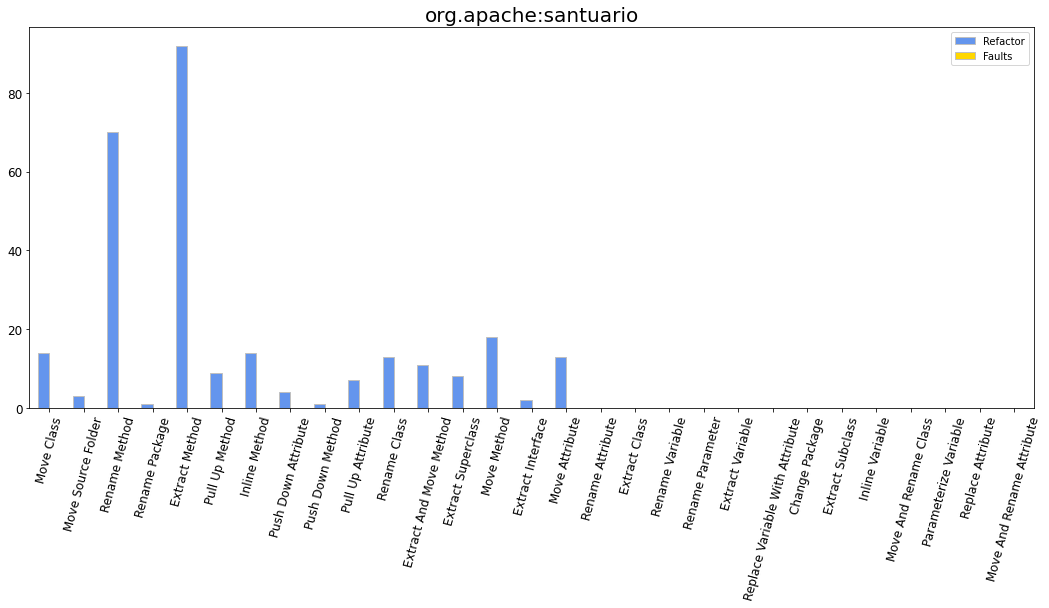

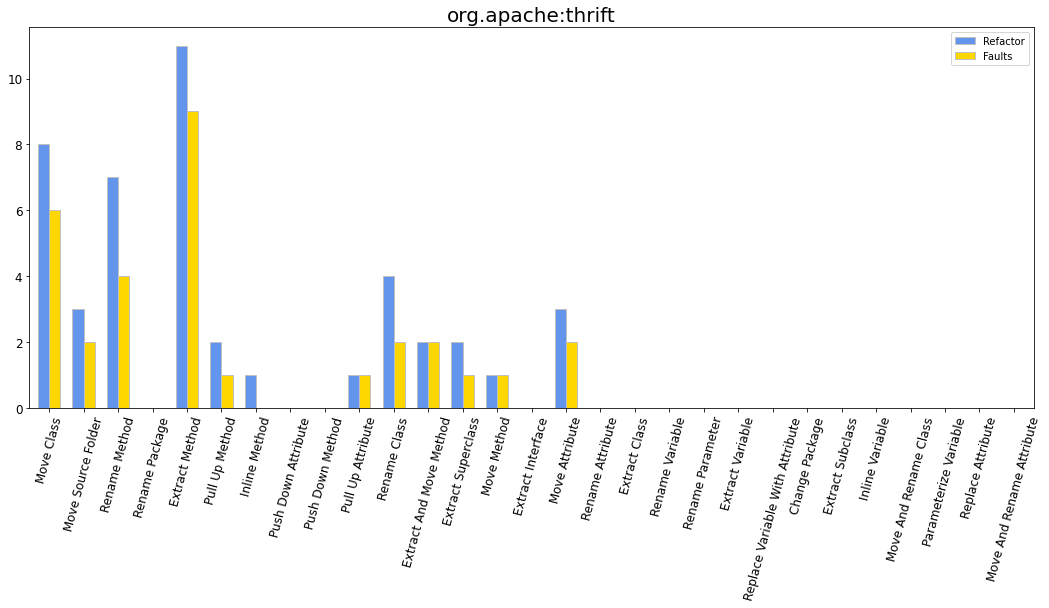

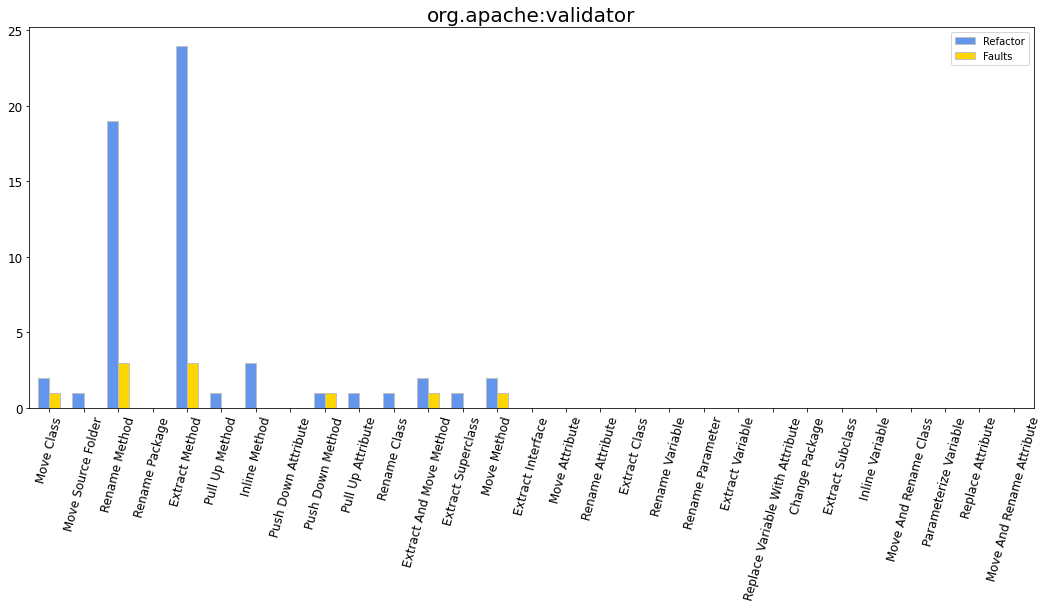

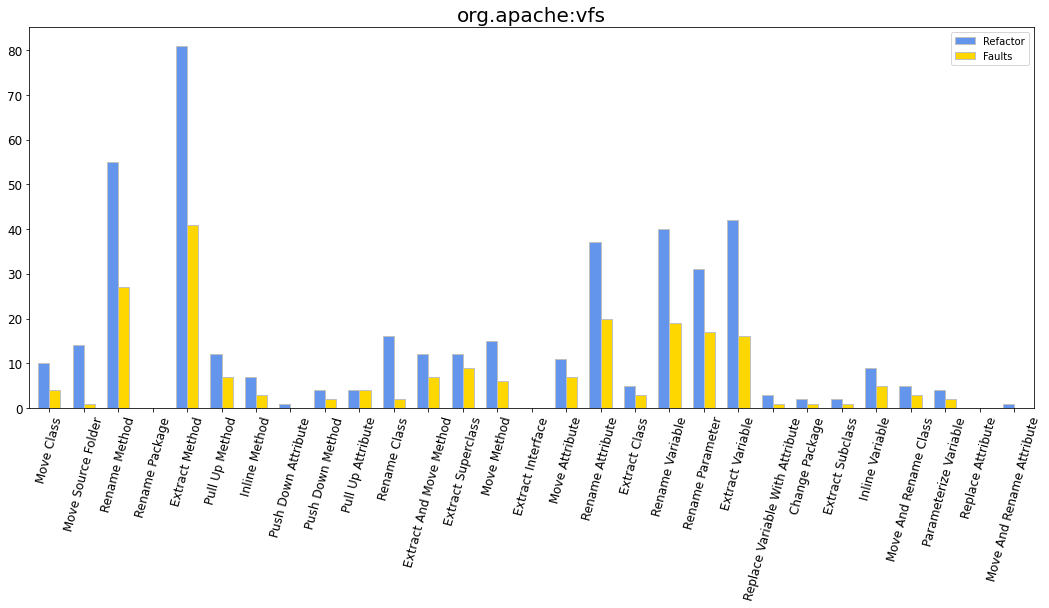

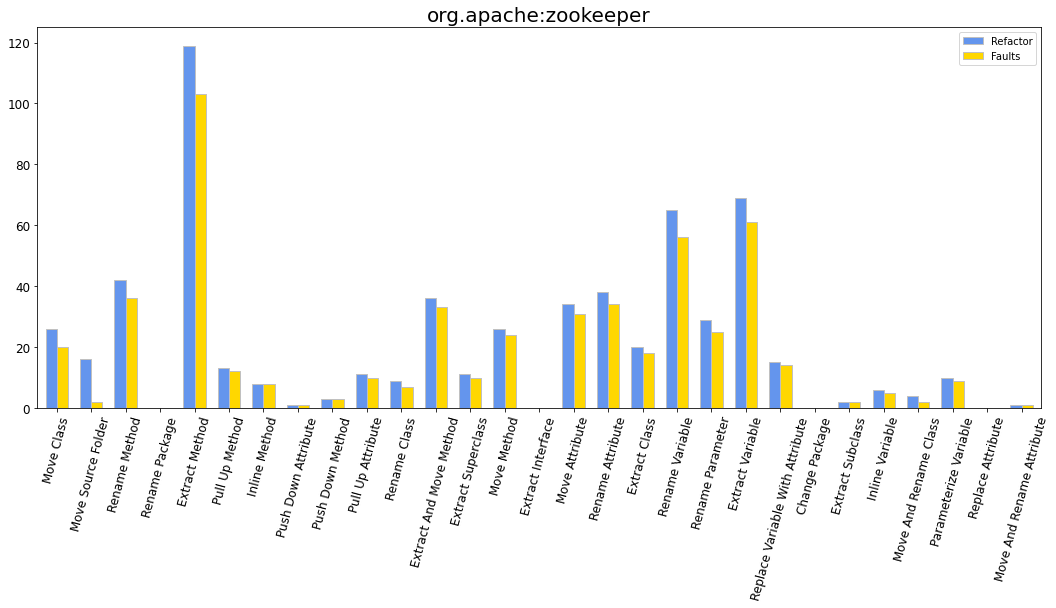

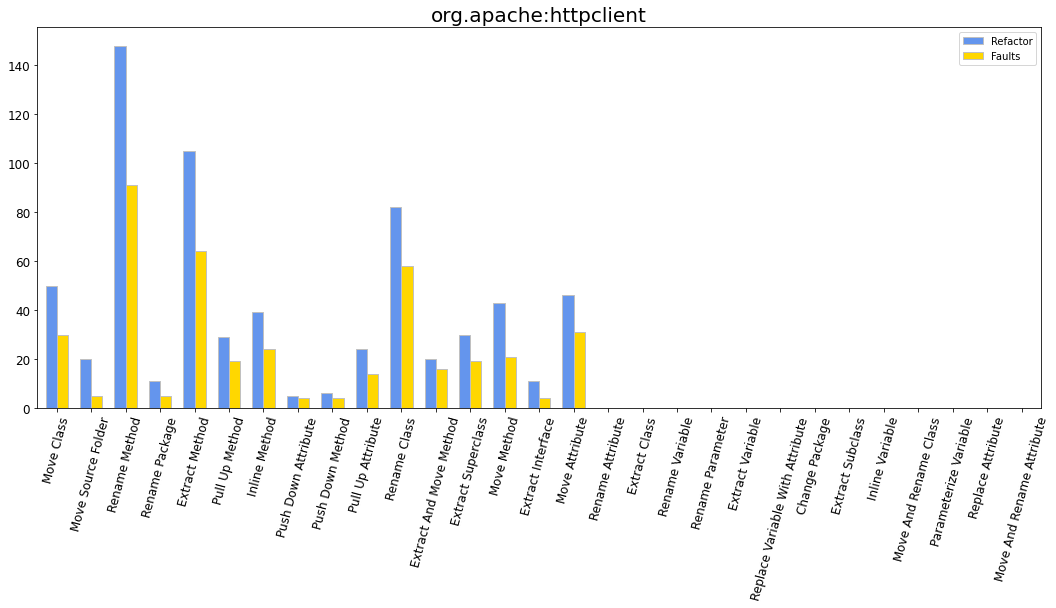

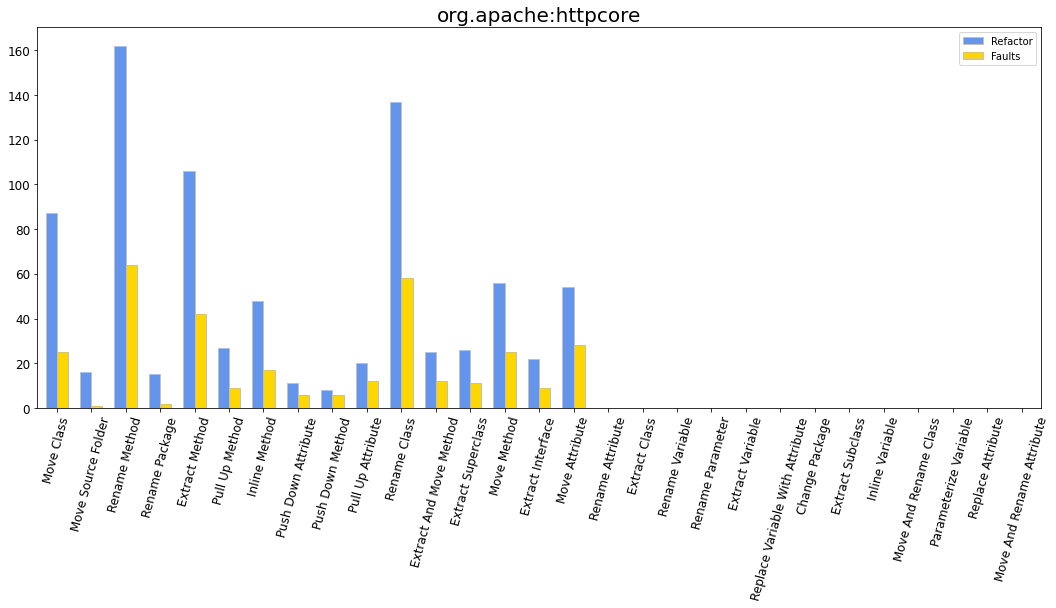

In [32]:
for i in szz_fault_inducing_commits.PROJECT_ID.unique():
    refact = pd.Series(pd.DataFrame(projects_refactor)[i], name="Refactor")
    faults = pd.Series(pd.DataFrame(projects_faults)[i], name="Faults")

    pd.concat([refact, faults], axis=1).plot(kind='bar', figsize=(18,7), rot=75, width=0.65, fontsize=12, color=('cornflowerblue','gold'),edgecolor = 'silver')
    plt.title(i, fontsize=20)